# Basic PyTorch Neural Network


**Note: I have done all the visualizations in another notebook( the svm one). Was not able to do the visualizations here because the Ram was occupied by the Neural Network(around 12.6 GB)**

**Used Pytorch for this project**

# Version 8

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.cuda.is_available()
# Using a GPU for faster calculations

True

In [4]:
torch.cuda.memory_allocated()
# After the notebook was run numerous times, to check the memory alloted to GPU as kaggle only allows 16GB.

0

## Create a model class


In [5]:
class Model(nn.Module):
    def __init__(self, in_features=9, h1=250, h2=250,h3=50,h4=250,h5=250, out_features=2):
# Used a really large number of neurons for this task.
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.fc3 = nn.Linear(h2, h3)            # hidden layer
        self.fc4 = nn.Linear(h3, h4)            # hidden layer
        self.fc5 = nn.Linear(h4, h5)            # hidden layer
        self.out = nn.Linear(h5, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        return x
#     Used ReLu activation function. Also used Sigmoid Function earlier but was not able to get the desired results.

In [6]:
# Instantiated the Model class using parameter defaults:
torch.manual_seed(32)
model = Model()
gpumodel= model.cuda()
# Instantiated the model on GPU

## Load the iris dataset

In [7]:
df = pd.read_csv('../input/nasa-nearest-earth-objects/neo.csv')
df = df.drop('name',axis=1)
df = df.drop('sentry_object',axis=1)
df = df.drop('orbiting_body',axis=1)
df = df.drop('id',axis=1)
# Dropping not so important classes. As sentry object is false and orbiting object is Earth.

#  Feature Engineering to add more accuracy.
df["hazardous"] = df["hazardous"].astype(int)
df['Mass'] = df.loc[:, 'absolute_magnitude'] ** (1/4)
df['avg_radius'] = (df.loc[:, 'est_diameter_min'] + df.loc[:,'est_diameter_max'])/2
df['Volume'] = (df.loc[:, 'avg_radius'] ** 3)*1.33
df['energy'] = (df.loc[:, 'Mass'] * df.loc[:, 'relative_velocity']**2)*0.5
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,Mass,avg_radius,Volume,energy
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0,2.022432,1.938843,9.693475,1.861897e+08
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1,2.114743,0.430073,0.105798,5.725983e+09
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0,2.054886,1.168268,2.120701,1.341332e+10
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0,2.170642,0.156150,0.005064,6.655956e+08
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1,2.117118,0.412613,0.093429,1.933472e+09


## Perform Train/Test/Split

In [8]:
# Using the scikit learn library.
X = df.drop('hazardous',axis=1).values
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X = sc.fit_transform(X)
y = df['hazardous'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train).cuda()
X_test = torch.FloatTensor(X_test).cuda()
# y_train = F.one_hot(torch.LongTensor(y_train))
# y_test = F.one_hot(torch.LongTensor(y_test))
# Not needed with cross entropy loss, was earlier implementing BCELoss but was facing error while converting tensors from long to float.
y_train = torch.LongTensor(y_train).cuda()
y_test = torch.LongTensor(y_test).cuda()

In [9]:
y_train

tensor([0, 1, 0,  ..., 0, 0, 0], device='cuda:0')

## Prepare DataLoader

In [10]:
from torch.utils.data import TensorDataset, DataLoader

data = df.drop('hazardous',axis=1).values
labels = df['hazardous'].values
class_weights =[]

Dataset = TensorDataset(torch.FloatTensor(data).cuda(),torch.LongTensor(labels).cuda())

In [11]:
Data_loader = DataLoader(Dataset, batch_size=105, shuffle=True)

In [65]:
# !pip install torchsampler

In [66]:
# from torchsampler import ImbalancedDatasetSampler

# train_loader = torch.utils.data.DataLoader(
#     iris,
#     sampler=ImbalancedDatasetSampler(iris),
#     batch_size=1000,
#     **kwargs
# )

# Was trying to use Imbalance Data Sampler from github but faced some error, so manually entered class weights.

## Define loss equations and optimizations


In [73]:
torch.manual_seed(4)
model = Model()
gpumodel= model.cuda()
weight = torch.FloatTensor([0.9,0.09]).cuda()
# Assigned weights to classes as the data provided was highly imbalanced.

In [74]:
weight

tensor([0.9000, 0.0900], device='cuda:0')

In [75]:
criterion = nn.CrossEntropyLoss(weight = weight).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000000001)
# Since the dataset was highly imbalanced was forced to use a extremely low learning rate or else the model was predicting all the values as either 1 or 0.

## Train the model

In [76]:
epochs = 3000000
losses = []
# Used too many epochs to further lower down the losses.
# The training went for around 9 hours using Kaggle Tesla GPUs.

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%1000 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 13113465.00000000
epoch: 1001  loss: 13073929.00000000
epoch: 2001  loss: 13034348.00000000
epoch: 3001  loss: 12994747.00000000
epoch: 4001  loss: 12955099.00000000
epoch: 5001  loss: 12915415.00000000
epoch: 6001  loss: 12875700.00000000
epoch: 7001  loss: 12835948.00000000
epoch: 8001  loss: 12796162.00000000
epoch: 9001  loss: 12756348.00000000
epoch: 10001  loss: 12716508.00000000
epoch: 11001  loss: 12676645.00000000
epoch: 12001  loss: 12636759.00000000
epoch: 13001  loss: 12596855.00000000
epoch: 14001  loss: 12556925.00000000
epoch: 15001  loss: 12516978.00000000
epoch: 16001  loss: 12477010.00000000
epoch: 17001  loss: 12437038.00000000
epoch: 18001  loss: 12397044.00000000
epoch: 19001  loss: 12357042.00000000
epoch: 20001  loss: 12317022.00000000
epoch: 21001  loss: 12276988.00000000
epoch: 22001  loss: 12236946.00000000
epoch: 23001  loss: 12196895.00000000
epoch: 24001  loss: 12156824.00000000
epoch: 25001  loss: 12116734.00000000
epoch: 26001  loss: 1207

KeyboardInterrupt: 

## Plot the loss function

In [80]:
epochs = 720465

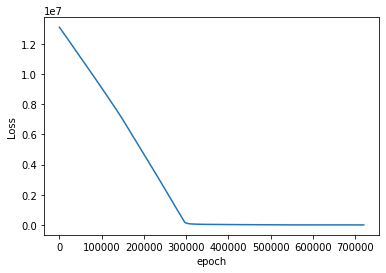

In [81]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');
# Plotted the losses vs epochs.

## Validate the model


In [78]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

# The final loss was  turned out to be pretty low relative to where the model started.
# The losses could have been minimised further but was not able able to do that because of kaggles limits.

91.94483948


In [79]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
#         print(f'{i+1:2}. {str(y_val)} {y_val.argmax().item()} {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
# Accuracy


16206 out of 18168 = 89.20% correct


Got an accuracy of around 90 percent. That is pretty good!

In [82]:
y_val


tensor([-6528206., -6531831.], device='cuda:0')

In [83]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')